In [1]:
import tensorflow as tf
from keras import layers, datasets, models
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time

2024-06-18 20:22:04.581136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 20:22:04.581278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 20:22:04.708205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(X_train, y_train), (X_test,y_test) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
train_data = np.concatenate((X_train, X_test), axis = 0)
train_labels = np.concatenate((y_train, y_test), axis = 0)

In [4]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"Concatenated train data shape = {train_data.shape}")
print()
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")
print(f"Concatenated train data shape = {train_labels.shape}")

X_train.shape = (60000, 28, 28)
X_test.shape = (10000, 28, 28)
Concatenated train data shape = (70000, 28, 28)

y_train.shape = (60000,)
y_test.shape = (10000,)
Concatenated train data shape = (70000,)


In [5]:
train_data = (train_data - 127.5) / 127.5

In [6]:
train_data.min()

-1.0

In [7]:
batch_size = 256
buffer_size = train_data.shape[0] // 2

def batched_dataset(images, labels, batch_size):
  
    labels = labels

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True) 
    
    return dataset

In [8]:
batched_train_data = batched_dataset(train_data, train_labels, batch_size)

In [9]:
len(batched_train_data)

273

In [10]:
train_data.shape[0]/batch_size

273.4375

In [11]:
def sbplt(rows, cols, data, labels):

  plt.figure(figsize = (rows*1,cols*1))

  for i in range (rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(data[i], cmap = 'gray')
    if len(labels)!=0 :
      plt.title(labels[i])
    plt.axis('off')

  plt.tight_layout()
  plt.show()
  return

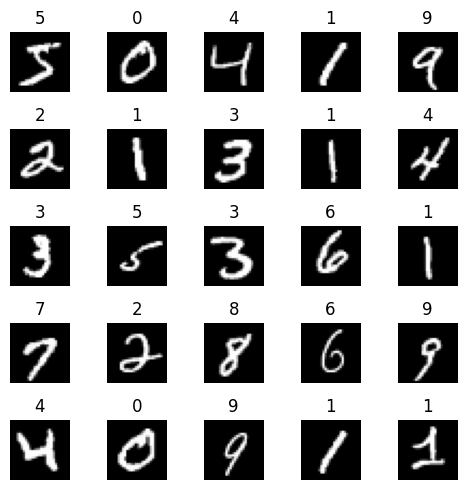

In [12]:
sbplt(5,5,train_data, train_labels)

## Generator

In [13]:
noise_dim = 100

def build_generator():
    
    noise_input_layer = layers.Input(shape=(noise_dim,), name='noise_input_layer')
    noise = layers.Dense(7 * 7 * 128, activation='relu')(noise_input_layer)
    noise = layers.Reshape((7, 7, 128))(noise)
    
    label_input_layer = layers.Input(shape=(1,), name='label_input_layer')
    label_embedding = layers.Embedding(input_dim=10, output_dim=50, name='label_embedding_layer')(label_input_layer)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(7 * 7 * 128, activation='relu')(label_embedding)
    label_embedding = layers.Reshape((7, 7, 128))(label_embedding)

    merge = layers.Concatenate(axis=-1)([noise, label_embedding])

    x = layers.Conv2D(128, activation='relu', padding='same', kernel_size=(3, 3))(merge)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(64, activation='relu', padding='same', kernel_size=(3, 3))(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.UpSampling2D()(x)

    output_layer = layers.Conv2D(1, activation='tanh', padding='same', kernel_size=(3, 3), name='output_layer')(x)

    return models.Model(inputs=[noise_input_layer, label_input_layer], outputs=output_layer, name='generator')

generator = build_generator()
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input_layer   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding_la… │ (None, 1, 50)     │        500 │ label_input_laye… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input_layer   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ label_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6272)      │    633,472 │ noise_input_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6272)      │    319,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 256) │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 128) │    295,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 128) │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     73,792 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 28, 28, 1) │        577 │ up_sampling2d_1[… │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,324,021 (5.05 MB)

 Trainable params: 1,323,637 (5.05 MB)

 Non-trainable params: 384 (1.50 KB)

## Discriminator

In [14]:
input_shape = (28,28,1)

def build_discriminator():
  
  input_img_layer = layers.Input(shape=input_shape, name='img_input_layer')
  label_input_layer = layers.Input(shape=(1,), name='label_input_layer')

  label_embedding = layers.Embedding(input_dim=10, output_dim=50, name='label_embedding_layer')(label_input_layer)
  label_embedding = layers.Flatten()(label_embedding)
  label_embedding = layers.Dense(28 * 28, activation='relu')(label_embedding)
  label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

  merge = layers.Concatenate(axis=-1)([input_img_layer, label_embedding])
  
  x = layers.Conv2D(filters = 32,
                    kernel_size=(3,3),
                    strides=(2,2),
                    activation=layers.LeakyReLU(0.2),
                    kernel_initializer = 'he_uniform',
                    padding='same')(merge)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Conv2D(filters = 64,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer = 'he_uniform',
                    padding='same')(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Conv2D(filters = 128,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer = 'he_uniform',
                    padding='same')(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Conv2D(filters = 256,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer = 'he_uniform',
                    padding='same')(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Flatten()(x)
  output_layer = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)
  
  return models.Model(inputs = [input_img_layer, label_input_layer], outputs = output_layer,  name = 'discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input_layer   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding_la… │ (None, 1, 50)     │        500 │ label_input_laye… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ label_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 784)       │     39,984 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_input_layer     │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ img_input_layer[… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        608 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 64)  │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 256) │    295,168 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 431,429 (1.65 MB)

 Trainable params: 430,533 (1.64 MB)

 Non-trainable params: 896 (3.50 KB)

## Testing for random noises

label = [[2]] and [[0.49412104]]


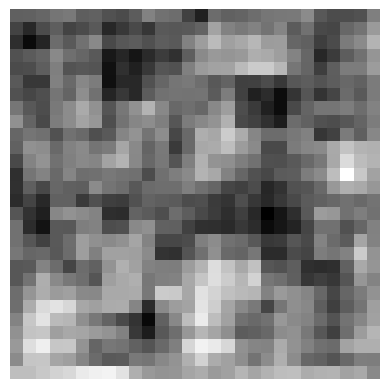

In [15]:
num_samples = 1
num_labels = 10

noises = tf.random.normal([num_samples, noise_dim])

label = np.random.choice(num_labels, size=(num_samples, 1))
label = tf.convert_to_tensor(label, dtype=tf.int32)

gen_img = generator([noises, label], training=False)

plt.imshow(gen_img[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')

disc_output = discriminator([gen_img, label], training=False)
print(f"label = {label} and {disc_output}")

plt.show()


## Optimizers for Generator and Discriminator

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)

## Loss functions of Generator and Discriminator

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [18]:
def discriminator_loss(real_outputs,fake_outputs):
  real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
  fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)
  total_loss = (real_loss + fake_loss)
  return total_loss

In [19]:
def generator_loss(predictions):
  return cross_entropy(tf.ones_like(predictions), predictions)

## Training

In [20]:
noise_dim = noise_dim
batch_size = batch_size

print(f"batch_size = {batch_size}")
print(f"noise_dim = {noise_dim}")

batch_size = 256
noise_dim = 100


In [21]:
@tf.function

def train_step (real_images, real_labels):
  
  noise = tf.random.normal([batch_size, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_images = generator([noise, real_labels], training = True)
    
    fake_outputs = discriminator([generated_images, real_labels], training  = True)
    real_outputs = discriminator([real_images, real_labels] , training = True)
    
    gen_loss = generator_loss(fake_outputs)
    disc_loss = discriminator_loss(real_outputs = real_outputs, fake_outputs = fake_outputs)
    
  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
  
  return disc_loss, gen_loss
    

In [22]:
# Test generator on following noises throughout training
num_samples = 16
num_labels = 10
noise_dim = 100

test_noises = tf.random.normal([num_samples,noise_dim])

test_labels = np.random.choice(num_labels, size=(num_samples, 1))
test_labels = tf.convert_to_tensor(test_labels, dtype = tf.int32)

In [23]:
import os

def generate_and_save_image(model, epoch, test_input, test_label):
    rows = 4
    cols = 4
    
    plt.figure(figsize=(rows*2, cols*2))
    plt.suptitle(f"Epoch = {epoch}")
    
    generated_images = model([test_input, test_label])
    
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.set_title(f"{test_label[i].numpy()}")
    
    plt.tight_layout()  
    
    if not os.path.exists("images"):
        os.makedirs("images")
    
    plt.savefig(f"images/image-at-epoch-{epoch:04d}.png") 
    plt.show()


In [24]:
# generate_and_save_image(generator, 0, test_noises, test_labels)

In [25]:
import os

# Define checkpoint directory and checkpoint prefix
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

epoch_var = tf.Variable(0, dtype=tf.int64)

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator,
                                 epoch_var=epoch_var)


# Restore the latest checkpoint if available
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint restored:", latest_checkpoint)
    current_epoch = int(epoch_var.numpy())
    print(f"Resumed training from epoch: {current_epoch}")
else:
    current_epoch = 0
    print("No checkpoint found, starting training from scratch.")

No checkpoint found, starting training from scratch.


In [26]:
def train(dataset, epochs, save_ckpt_after_every = 10):
    disc_losses = []
    gen_losses = []

    for epoch in range(current_epoch + 1, epochs + 1):
        start = time.time()

        for real_images, real_labels in dataset:
            disc_loss, gen_loss = train_step (real_images, real_labels)
        
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
        
        display.clear_output(wait=True)
        print(f"Epoch = {epoch}, disc_loss = {disc_loss}, gen_loss = {gen_loss}, time_taken = {time.time() - start} seconds")
        generate_and_save_image(model=generator, epoch=epoch, test_input=test_noises, test_label=test_labels)

        if epoch % save_ckpt_after_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"checkpoint saved for epoch = {epoch}")

        history = {
            'discriminator_losses': disc_losses,
            'generator_losses': gen_losses
        }

        print(f"history of epoch = {epoch} saved")
        print(f"epoch = {epoch+1} started")
    
    return history

Epoch = 50, disc_loss = 1.2536342144012451, gen_loss = 0.8026859164237976, time_taken = 7.482222557067871 seconds


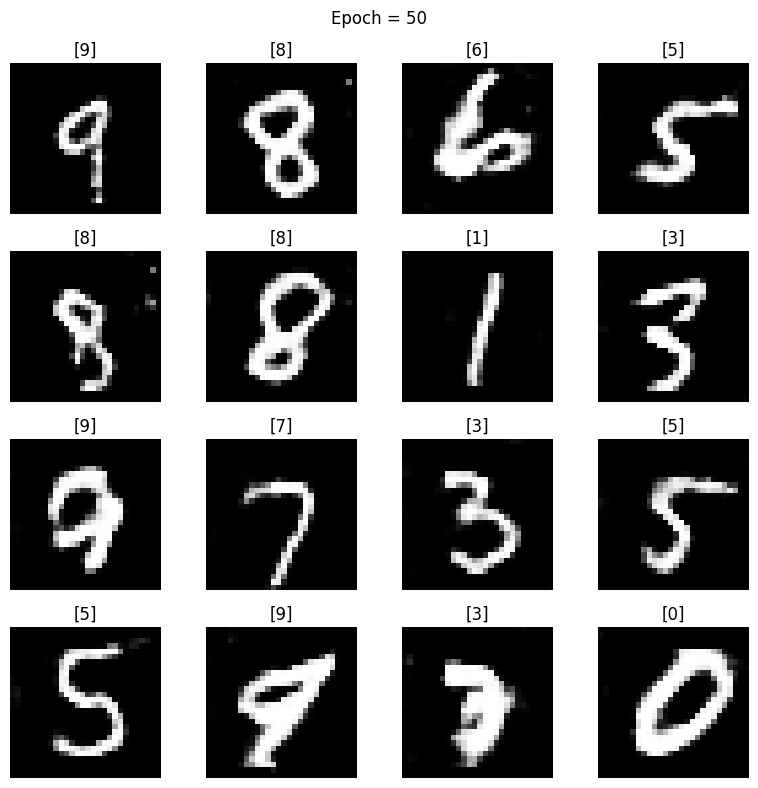

checkpoint saved for epoch = 50
history of epoch = 50 saved
epoch = 51 started


In [27]:
epochs = 50
history = train(batched_train_data, epochs = epochs)

In [28]:
import os
import pickle

# Ensure the output directory exists
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Save the history object to the output directory
output_path = os.path.join(output_dir, 'cgan-mnist-history.pkl')
with open(output_path, 'wb') as pickle_file:
    pickle.dump(history, pickle_file)


In [29]:
# Load the history from the pickle file
with open('cgan-mnist-history.pkl', 'rb') as pickle_file:
    loaded_history_pickle = pickle.load(pickle_file)

# Access the loaded history
discriminator_losses = loaded_history_pickle['discriminator_losses']
generator_losses = loaded_history_pickle['generator_losses']

In [30]:
generator.save("generator-mnist-cgan.h5")

In [35]:
discriminator.save("discriminator-mnist-cgan.h5")

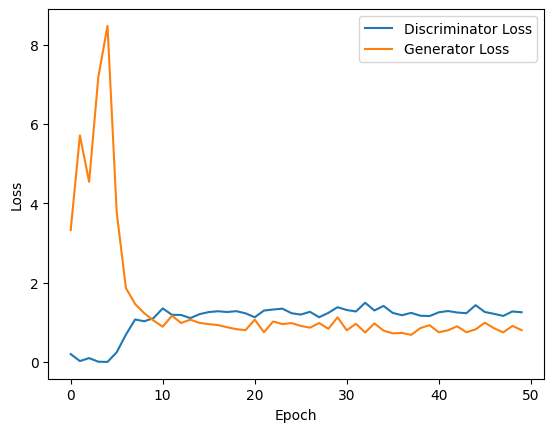

In [31]:
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
import shutil

# Define the directory containing the images and the output zip file
images_dir = '/kaggle/working/images'
output_zip = '/kaggle/working/images-mnist-cgan.zip'

# Zip the directory
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', images_dir)

print(f"Zipped {images_dir} to {output_zip}")


Zipped /kaggle/working/images to /kaggle/working/images-mnist-cgan.zip


In [33]:
# Define the directory containing the training_ckpt and the output zip file
images_dir = '/kaggle/working/training_checkpoints'
output_zip = '/kaggle/working/checkpoints-mnist-cgan.zip'

# Zip the directory
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', images_dir)

print(f"Zipped {images_dir} to {output_zip}")


Zipped /kaggle/working/training_checkpoints to /kaggle/working/checkpoints-mnist-cgan.zip
